## 1. Use the question/target variable you submitted and build a model to answer the question you created for the dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score





grad_data = pd.read_csv('https://query.data.world/s/qpi2ltkz23yp2fcaz4jmlrskjx5qnp', encoding="cp1252")

### Question: Using the different statistics from different colleges, can we predict their retention percentile (whether it is over or under 70%)?

In [2]:
to_drop = list(range(38, 56))
to_drop.extend([27, 9, 10, 11, 28, 60, 56])

grad_data1 = grad_data.drop(grad_data.columns[to_drop], axis=1)

drop_more = [0,1,2,3,6,8,11,12,14,15,18,21,23,29,32,33,34,35]
grad_data2 = grad_data1.drop(grad_data1.columns[drop_more], axis=1)
grad_data2.replace('NULL', np.nan, inplace=True)

grad_data2['hbcu'] = [1 if grad_data2['hbcu'][i]=='X' else 0 for i in range(len(grad_data2['hbcu']))]
grad_data2['hbcu'].value_counts()

grad_data2['hbcu'] = grad_data2.hbcu.astype('category')
    # convert more variables to factors
grad_data2[['level', 'control']] = grad_data2[['level', 'control']].astype('category')
grad_data2['retain_percentile'] = grad_data1['retain_percentile'].apply(lambda x: 1 if x >= 70 else 0)

abc = list(grad_data2.select_dtypes('number')) #select function to find the numeric variables and create a list  
grad_data2[abc] = MinMaxScaler().fit_transform(grad_data2[abc])
random.seed(1234)
category_list = list(grad_data2.select_dtypes('category'))
grad_data2 = pd.get_dummies(grad_data2, columns = category_list)
grad_data2 = grad_data2.dropna()

In [3]:
def retention_class(x):
    Train, Test = train_test_split(grad_data2,  train_size = 55, stratify = grad_data2.retain_percentile, random_state=42) 
    Tune, Test = train_test_split(Test,  train_size = .5, stratify= Test.retain_percentile)
    dtree = DecisionTreeClassifier()

    # separate features and target variable
    X_train = Train.drop('retain_percentile', axis=1)
    y_train = Train['retain_percentile']
    X_test = Test.drop('retain_percentile', axis=1)
    y_test = Test['retain_percentile']

    # Fit the model on the training data
    dtree.fit(X_train, y_train)

    # Predict on the test data
    y_pred_dtree = dtree.predict(X_test)

    # Calculate precision
    precision = precision_score(y_test, y_pred_dtree)
    print(precision)
     
retention_class(grad_data)

0.8846153846153846


## 2. Build a kNN model to predict your target variable using 3 nearest neighbors. Make sure it is a classification problem, meaning if needed changed the target variable.

In [4]:
import random
random.seed(1234)

grad_data3 = pd.get_dummies(grad_data2, columns=['retain_percentile'])




train, test = train_test_split(grad_data3, test_size=0.4, stratify=grad_data3['retain_percentile_1.0'], random_state=12345) 
test, val = train_test_split(test, test_size=0.5, stratify=test['retain_percentile_1.0'], random_state=12345)

#! make sure you also drop signed up 0, so that the model isn't just memorizing


X_train = train.drop(['retain_percentile_0.0', 'retain_percentile_1.0'], axis=1).values
y_train = train['retain_percentile_1.0'].values

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)



X_val = val.drop(['retain_percentile_0.0', 'retain_percentile_1.0'], axis=1).values
y_val = val['retain_percentile_1.0'].values

y_val_pred = neigh.predict(X_val)

print(neigh.score(X_val, y_val))


0.8484848484848485


## 3. Create a dataframe that includes the test target values, test predicted values, and test probabilities of the positive class.

In [5]:
import pandas as pd

y_pred = neigh.predict(X_val)
y_prob = neigh.predict_proba(X_val)[:, 1] 

# Create DataFrame
results_df = pd.DataFrame({
    'Actual': y_val,
    'Predicted': y_pred,
    'Probability_Positive_Class': y_prob
})

# Display the first few rows
results_df.head(10)


,Actual,Predicted,Probability_Positive_Class
0,False,False,0.000000
1,False,True,0.666667
2,False,False,0.000000
3,False,False,0.000000
4,True,False,0.000000
5,False,False,0.000000
6,False,False,0.000000
7,True,False,0.333333
8,False,False,0.000000
9,False,False,0.000000


## 4. No code question: If you adjusted the k hyperparameter what do you think would happen to the threshold function? Would the confusion look the same at the same threshold levels or not? Why or why not?

The K hyperparameter that we choose has a large effect on the threshold function. If the k value is lower, then fewer points are taken into consideration, meaning that the threshold function results will be more extreme to certain ends (like seeing 0.1 or 0.9). Our threshold function takes those results from the model and then determines whether it will be classified as one thing or the other. Therefore lowering the k hyperparameter would make the threshold function more sharp and split, while raising the k hyperparameter would make the threshold less sharp and decisive. 

The confusion matrix would not look the same at the same threshold levels because as the k changes, the confusion matrix would show that the model is making sharper decisions as k goes down, and softer decisions as k goes up. The confusions matrix would change as this k value is changing, as the predictions the model is spitting out would differ, and therefore certain things would be placed above or below the threshold differently. 

## 5. Evaluate the results using the confusion matrix. Then "walk" through your question, summarize what concerns or positive elements do you have about the model as it relates to your question? 

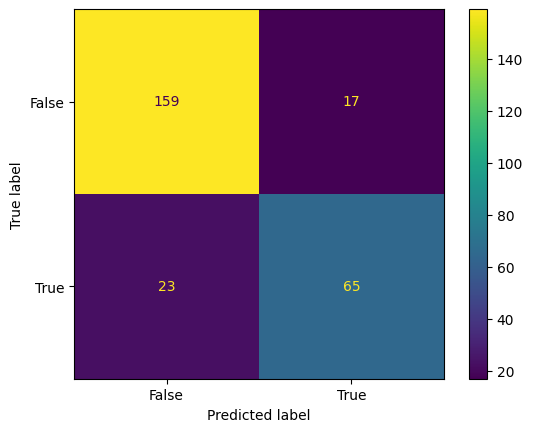

In [6]:
cm = confusion_matrix(y_val,y_val_pred, labels=neigh.classes_)
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=neigh.classes_)  
disp.plot()
plt.show()


From our confusion matrix, we can see that there were 159 true negatives, 65 true positives, 17 false positives and 23 false negatives. Our question was whether we can use the features in the dataset to predict whether a school will be in a retention percentile over 70%. We can see that the model on average was able to identify 159 true negatives effectively, while only classifying 23 false negatives. The model was able to classify 65 true positives, however there were also 17 false positives, which is a large percentage of the predictions. This makes sense, because we are trying to classify the data based on whether it is above or below the 70% percentile mark, meaning that there will be more data points below that mark and therefore the model has a better chance of making that correct prediction. One concern of mine is that the precision score isn't accurate enough for this model to be effectively used in the real world.

## 6. Create two functions: One that cleans the data & splits into training|test and one that allows you to train and test the model with different k and threshold values, then use them to optimize your model (test your model with several k and threshold combinations). Try not to use variable names in the functions, but if you need to that's fine. (If you can't get the k function and threshold function to work in one function just run them separately.) 


### Cleaning function

In [7]:
def clean_and_split_data(df, target, test_size=0.4, val_size=0.5, random_state=2004):
    train, test = train_test_split(grad_data3, test_size=0.4, stratify=df[target], random_state=12345) 
    test, val = train_test_split(test, test_size=0.5, stratify=test[target], random_state=12345)

    
    X_train = train.drop([target], axis=1).values
    y_train = train[target].values
    X_val = val.drop([target], axis=1).values
    y_val = val[target].values
    
    return train, test, val

### Training and testing function

In [8]:
def train_and_test(X_train, y_train, X_val, y_val, k=3, threshold=0.5):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    
    
    y_pred = neigh.predict(X_val)


    cm = confusion_matrix(y_val, y_pred)
    return cm

In [9]:
def chooseK(k, X_train, y_train, X_test, y_test):
    random.seed(1)
    print("calculating... ", k, "k")    # I'll include this so you can see the progress of the function as it runs
    class_knn = KNeighborsClassifier(n_neighbors=k)
    class_knn.fit(X_train, y_train)
    
    # calculate accuracy
    accu = class_knn.score(X_test, y_test)
    return accu

## 7. How well does the model perform? Did the interaction of the adjusted thresholds and k values help the model? Why or why not?

In [10]:
clean_and_split_data(grad_data3,'retain_percentile_1.0', test_size=0.4, val_size=0.5, random_state=2004)

(      student_count  awards_per_value  exp_award_value  exp_award_percentile  \
 1619       0.031154          0.169220         0.072598                  0.99   
 2034       0.006055          0.167031         0.012211                  0.36   
 1267       0.009764          0.129832         0.020265                  0.73   
 2375       0.004838          0.172137         0.000000                  0.00   
 1160       0.011045          0.154632         0.017680                  0.63   
 ...             ...               ...              ...                   ...   
 3016       0.178832          0.167031         0.017532                  0.86   
 1403       0.015371          0.156090         0.011141                  0.52   
 506        0.001640          0.107950         0.016575                  0.58   
 634        0.154331          0.195478         0.010362                  0.44   
 2957       0.016923          0.125456         0.017101                  0.60   
 
         ft_pct  fte_perce

In [11]:
chooseK(5, X_train, y_train, X_val, y_val)

calculating...  5 k


0.875

In [12]:
train_and_test(X_train, y_train, X_val, y_val, k=5, threshold=0.5)

array([[162,  14],
       [ 19,  69]])

Yes, my model was improved by doing this. I used the chooseK function given to us in class and was able to find the best k value that led to the most accurate knn model. The k value started off being 3, and this was a relatively low number, meaning that the model may have been overfitting. I then raised it to 5 (after that the accuracy starts to taper off), and the accuracy went up, meaning the model was better able to find the overall relationship between the variables. The model was able to raise the number of true negatives to 162, and the number of true positives to 69, with an overall accuracy of around 88%. 

## 8. Choose another variable as the target in the dataset and create another kNN model using the two functions you created in step 7. 

In [13]:
clean_and_split_data(grad_data3, 'hbcu_1', test_size=0.4, val_size=0.5, random_state=2004)

(      student_count  awards_per_value  exp_award_value  exp_award_percentile  \
 1531       0.002275          0.204230         0.009745                  0.22   
 2349       0.016159          0.154632         0.019225                  0.69   
 446        0.057300          0.148796         0.012136                  0.61   
 2105       0.010416          0.168490         0.010131                  0.25   
 824        0.013408          0.161196         0.026851                  0.85   
 ...             ...               ...              ...                   ...   
 683        0.000958          0.135667         0.006854                  0.09   
 1619       0.031154          0.169220         0.072598                  0.99   
 2665       0.055014          0.117433         0.007000                  0.13   
 399        0.153262          0.161196         0.014757                  0.77   
 2062       0.005108          0.151714         0.016064                  0.56   
 
         ft_pct  fte_perce

In [14]:
# redefining these values as the function didn't do this properly
X_train = train.drop(['hbcu_1', 'hbcu_0'], axis=1).values
y_train = train['hbcu_1'].values
X_val = val.drop(['hbcu_1', 'hbcu_0'], axis=1).values
y_val = val['hbcu_1'].values

train_and_test(X_train, y_train, X_val, y_val, k=5, threshold=0.5)

array([[249,   1],
       [  7,   7]])

From this new model we created, we can see that the model is able to very accurately predict true negatives, and there is also an ample amount of these in the data. Out of the 256 labeled false by the model, 249 of them were correct! However, there aren't a lot of positives in the dataset to begin with (in this case this means that there aren't many historically black universities in the data set), which means that although the model got 7 correct, it labeled one false which was true, out of 8 positives. 